<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/projects/Candies_detection/Lesson16_YOLO_OpenCV_Algebra_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Урок 16: Подготовка датасета + Обучение YOLOv8 + Аугментации + Линейная алгебра

Этот ноутбук включает:
1. Полную подготовку кастомного датасета.
2. Проверку структуры и валидацию данных.
3. Обучение YOLOv8 модели.
4. Примеры аугментаций с OpenCV.
5. Теорию и практику по линейной алгебре: аффинные преобразования.

---

## 📦 Установка необходимых библиотек

In [ ]:
!pip install -q ultralytics duckduckgo-search opencv-python-headless matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.6 MB/s eta 0:00:00


## labelImg - программа для разметки изображений

Открыл интерфейс, и разметил в YOLO формат все фотографии.


# Загрузка файлов изображения конфет с аннотациями

✅ Шаг 1: Подключение библиотек и определение путей

In [1]:
import os
import shutil
import random

# Папка, где сейчас лежат все изображения и разметки
base_path = '/content/candies'
image_exts = ['.jpg', '.jpeg', '.png']  # допустимые расширения

# Новая структура директорий
for split in ['train', 'val']:
    os.makedirs(os.path.join(base_path, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(base_path, 'labels', split), exist_ok=True)


✅ Шаг 2: Получение списка всех изображений


In [2]:
# Получаем только изображения (без .txt)
all_images = [f for f in os.listdir(base_path) if os.path.splitext(f)[1].lower() in image_exts]
print(f"Всего изображений найдено: {len(all_images)}")
print(all_images[:5])

Всего изображений найдено: 242
['252.jpg', '255.jpg', '224.jpg', '242.jpg', '234.jpg']


✅ Шаг 3: Перемешиваем и делим на train/val

In [3]:
random.shuffle(all_images)

split_ratio = 0.8  # 80% train, 20% val
split_index = int(len(all_images) * split_ratio)

train_images = all_images[:split_index]
val_images = all_images[split_index:]

print(f"Train: {len(train_images)} изображений")
print(f"Val: {len(val_images)} изображений")



Train: 193 изображений
Val: 49 изображений


✅ Шаг 4: Копирование файлов в нужные папки

In [4]:
def move_files(images, split):
    for img_file in images:
        name, _ = os.path.splitext(img_file)
        label_file = name + '.txt'

        # Пути к файлам
        src_img = os.path.join(base_path, img_file)
        src_lbl = os.path.join(base_path, label_file)

        dst_img = os.path.join(base_path, 'images', split, img_file)
        dst_lbl = os.path.join(base_path, 'labels', split, label_file)

        # Копируем
        if os.path.exists(src_img) and os.path.exists(src_lbl):
            shutil.move(src_img, dst_img)
            shutil.move(src_lbl, dst_lbl)
        else:
            print(f"❌ Пропущен {img_file} или {label_file}")

# Перемещаем
move_files(train_images, 'train')
move_files(val_images, 'val')


## ✅ Валидация структуры датасета

In [5]:
import os

def validate_dataset_structure(base_path='candies', nc=6):
    errors = []
    for split in ['train', 'val']:
        img_dir = os.path.join(base_path, 'images', split)
        lbl_dir = os.path.join(base_path, 'labels', split)
        if not os.path.exists(img_dir):
            errors.append(f"❌ Отсутствует папка изображений: {img_dir}")
        if not os.path.exists(lbl_dir):
            errors.append(f"❌ Отсутствует папка разметки: {lbl_dir}")
        else:
            for file in os.listdir(img_dir):
                if file.endswith('.jpg') or file.endswith('.png'):
                    label_file = os.path.join(lbl_dir, file.rsplit('.', 1)[0] + '.txt')
                    if not os.path.exists(label_file):
                        errors.append(f"❌ Нет разметки для: {file}")
                    else:
                        with open(label_file, 'r') as f:
                            for i, line in enumerate(f.readlines()):
                                parts = line.strip().split()
                                if len(parts) != 5:
                                    errors.append(f"❌ Неверный формат в {label_file}, строка {i+1}")
                                else:
                                    class_id = int(parts[0])
                                    if class_id >= nc:
                                        errors.append(f"❌ Некорректный class_id {class_id} в {label_file}")
    if not errors:
        print("✅ Структура и аннотации в порядке!")
    else:
        for e in errors:
            print(e)

validate_dataset_structure()


✅ Структура и аннотации в порядке!


## ⚙️ Обучение YOLOv8

Создай в корне candies/ файл data.yaml с указанием путей и числа классов:

yaml

# candies/data.yaml
path: candies   # корень датасета
train: images/train
val:   images/val
nc:  X         # заменить X на число классов
names: ['класс0', 'класс1', ...]  # список имён классов длины nc

data.yaml
path: candies   # корень датасета
train: images/train
val:   images/val
nc:  5         # число классов
names: ['Мишка на севере', 'Мишка косолапый', 'Красная шапочка', 'Трюфель', 'Аленка']  # список имён классов длины nc

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

# train
model.train(
    data='/content/candies/data.yaml',
    imgsz=640,
    batch=16,
    epochs=50,
    name='candies_v8'
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 118MB/s]


Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/candies/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=candies_v8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

100%|██████████| 22.2M/22.2M [00:00<00:00, 271MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    752482  ultralytics.nn.modules.head.Detect           [6, [64, 128, 256]]           
Model summary: 129 layers, 3,012,018 parameters, 3,012,002 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 129MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1707.6±935.8 MB/s, size: 105.6 KB)


train: Scanning /content/candies/labels/train... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<00:00, 2005.05it/s]

train: New cache created: /content/candies/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 596.9±495.3 MB/s, size: 127.8 KB)


val: Scanning /content/candies/labels/val... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<00:00, 1502.79it/s]

val: New cache created: /content/candies/labels/val.cache


Plotting labels to runs/detect/candies_v8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/candies_v8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.05G      1.651      4.152      1.414         44        640:  31%|███       | 4/13 [00:02<00:04,  2.04it/s]

       1/50      2.05G      1.685      4.147      1.414         84        640:  38%|███▊      | 5/13 [00:02<00:03,  2.40it/s]
100%|██████████| 755k/755k [00:00<00:00, 16.9MB/s]
       1/50      2.38G      1.546      4.086      1.363          2        640: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


                   all         49         93    0.00608      0.786      0.119     0.0841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.78G      1.189      3.306      1.194          4        640: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         49         93    0.00674      0.943      0.202      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.8G      1.091      2.526       1.15          1        640: 100%|██████████| 13/13 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         49         93       0.78      0.177      0.379      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.81G      1.177      2.222      1.175          5        640: 100%|██████████| 13/13 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         49         93      0.655      0.125      0.329      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.84G      1.086      2.041      1.133          7        640: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         49         93      0.556      0.281      0.437      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.86G      1.022      1.829       1.08          2        640: 100%|██████████| 13/13 [00:03<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         49         93      0.655      0.313      0.554      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.87G      1.236      1.951      1.256          2        640: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         49         93      0.653      0.515      0.594      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.89G      1.121      1.969      1.183          1        640: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         49         93      0.765      0.502      0.613      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.9G      1.042      1.641      1.106          2        640: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         49         93      0.646      0.648      0.668      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.92G     0.9921      1.554      1.081          3        640: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         49         93      0.684      0.703      0.768      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.94G      1.019      1.586      1.113          2        640: 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         49         93      0.843      0.635      0.707      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.96G      1.032      1.461      1.107          5        640: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         49         93      0.744      0.803      0.835      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.96G      1.039      1.454      1.109          7        640: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         49         93      0.779      0.811      0.845      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.99G     0.9937      1.371       1.08          4        640: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         49         93      0.865      0.794      0.892      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.01G     0.9889      1.285      1.078          1        640: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         49         93      0.874      0.833      0.935      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.03G     0.9806      1.232      1.081          5        640: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         49         93      0.695      0.958      0.936      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.03G     0.8746      1.736     0.9939          0        640: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         49         93      0.837      0.895      0.931       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.06G     0.9411      1.128      1.088          4        640: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         49         93      0.915      0.732      0.907      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.08G     0.9842      1.362      1.097          1        640: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         49         93      0.947      0.835      0.917        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.1G     0.8857      1.065       1.04          4        640: 100%|██████████| 13/13 [00:03<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         49         93      0.903       0.85      0.928      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       3.1G     0.8777      1.119      1.035          4        640: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         49         93      0.857      0.894      0.875      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.13G      1.089      1.649      1.234          1        640: 100%|██████████| 13/13 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         49         93      0.933      0.847      0.974      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.15G     0.8761      1.105      1.042          1        640: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         49         93      0.908       0.89      0.959      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.16G      0.832      1.061      1.012          1        640: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         49         93      0.968      0.909      0.981      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.17G     0.8308      1.005      1.051          2        640: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         49         93      0.932      0.891      0.981      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.2G      0.824     0.9894      1.025          4        640: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         49         93      0.897      0.917      0.969      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.21G     0.8935      1.025      1.043          4        640: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         49         93      0.947      0.894      0.964      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.23G     0.8978      1.133      1.067          2        640: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         49         93      0.924      0.929      0.981      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.24G     0.7896      0.912      0.987          4        640: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         49         93      0.901       0.95      0.979      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.27G     0.8128     0.9089      1.016          4        640: 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         49         93      0.915      0.893      0.974       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.28G     0.8216      0.902      1.008          3        640: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         49         93      0.898      0.912      0.982      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       3.3G     0.8529     0.9414      1.067          1        640: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         49         93      0.875      0.955      0.988      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.31G      0.839     0.9208      1.033          1        640: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         49         93      0.848      0.963      0.903      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.33G     0.8548     0.9253      1.062          2        640: 100%|██████████| 13/13 [00:03<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         49         93      0.848      0.978      0.904      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.35G      0.756     0.8098     0.9957          4        640: 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         49         93      0.874      0.969      0.957      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.37G      0.731     0.7728     0.9704          5        640: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         49         93      0.955      0.974      0.981      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.38G     0.7416     0.8023     0.9937          2        640: 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         49         93      0.962      0.971      0.989      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       3.4G     0.7444     0.8732      1.026          1        640: 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         49         93      0.964      0.959       0.99      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.42G     0.7728     0.7927     0.9936          2        640: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         49         93      0.958      0.959      0.988      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.44G     0.7089     0.7779      0.995          4        640: 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         49         93      0.941      0.957      0.979      0.782


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.44G     0.6708     0.8459     0.9523          2        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         49         93       0.93      0.957       0.98      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.47G     0.6682     0.8328     0.9269          5        640: 100%|██████████| 13/13 [00:02<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         49         93      0.915      0.972      0.986       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.49G     0.6184     0.7702     0.9311          2        640: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         49         93      0.968      0.919      0.986      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       3.5G     0.5982     0.7663      0.897          1        640: 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         49         93      0.928      0.974      0.987      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.51G     0.5964     0.7159     0.8931          2        640: 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         49         93      0.919      0.977      0.987      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.54G     0.5832     0.7802     0.9077          1        640: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         49         93      0.975      0.925      0.988      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.56G     0.6062     0.7678     0.9289          4        640: 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         49         93      0.976      0.941      0.988      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.57G     0.5657     0.7165     0.8866          2        640: 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         49         93      0.974      0.942      0.989      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.58G     0.5477     0.6751     0.8915          2        640: 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         49         93       0.97      0.951      0.989      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.61G     0.5553     0.6892     0.8939          2        640: 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         49         93      0.964      0.946      0.987      0.793



50 epochs completed in 0.071 hours.
Optimizer stripped from runs/detect/candies_v8/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/candies_v8/weights/best.pt, 6.2MB

Validating runs/detect/candies_v8/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


                   all         49         93      0.929      0.974      0.987      0.801
       Мишка косолапый         14         16      0.986          1      0.995      0.831
               Трюфель         18         20      0.905      0.958      0.979      0.715
              Батончик         18         19      0.855      0.933      0.973      0.758
       Красная шапочка         21         22      0.992      0.955      0.988      0.767
         Птичье молоко         12         14      0.977          1      0.995      0.817
                Аленка          2          2      0.856          1      0.995       0.92
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/candies_v8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c3360b8a8d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

1. Посмотреть сводные метрики

In [ ]:
from ultralytics import YOLO

# 1) Загрузить лучший чекпоинт
model = YOLO('/content/runs/detect/candies_v8/weights/best.pt')

# 2) Запустить валидацию заново (с графиками)
metrics = model.val(
    data='/content/candies/data.yaml',
    imgsz=640,
    batch=16,
    plots=True      # создаст confusion_matrix.png, pr_curves.png и т.д.
)
print(metrics)     # выведет precision, recall, mAP50, mAP50-95


Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1829.0±682.8 MB/s, size: 108.6 KB)


val: Scanning /content/candies/labels/val.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


                   all         49         93      0.909      0.987      0.986      0.804
       Мишка косолапый         14         16      0.972          1      0.995      0.831
               Трюфель         18         20      0.908      0.983      0.979      0.718
              Батончик         18         19      0.824      0.986      0.967      0.766
       Красная шапочка         21         22       0.98      0.955      0.988      0.764
         Птичье молоко         12         14      0.966          1      0.995      0.822
                Аленка          2          2      0.804          1      0.995       0.92
Speed: 4.8ms preprocess, 12.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c33603b7d50>
curves: ['Precision-Recal

#2. Визуальный инференс на примерах

## 2.1. Одно изображение


image 1/1 /content/candies/images/val/357.jpg: 640x480 1 Красная шапочка, 1 Птичье молоко, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


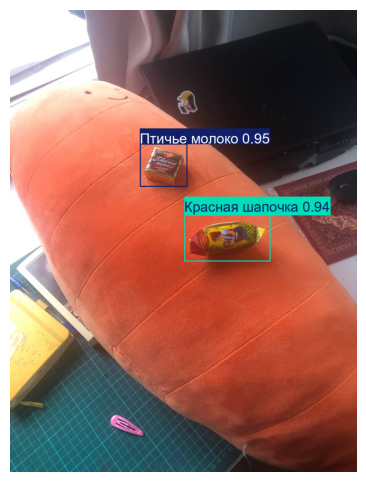

In [ ]:
import matplotlib.pyplot as plt
import cv2

# путь к случайному валид–изображению
img = '/content/candies/images/val/357.jpg'

results = model.predict(source=img, conf=0.25, imgsz=640)
res_img = results[0].plot()  # отрисованный np.array
rgb = cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB)   # BGR → RGB


plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(rgb)
plt.show()


## 🖼️ Инференс

In [ ]:
results = model('dataset/images/stop_sign_0.jpg', save=True)
results[0].show()


1. Диагностика и баланс классов
1.1. Проверь, сколько примеров каждого класса в train/val.

In [ ]:
from collections import Counter
import glob

labels = glob.glob('candies/labels/train/*.txt')
cnt = Counter()
for f in labels:
    for line in open(f):
        cls = int(line.split()[0])
        cnt[cls] += 1
print(cnt)


Counter({1: 84, 4: 69, 3: 65, 0: 63, 2: 54, 5: 13})


## 🧪 OpenCV: Аугментации изображений

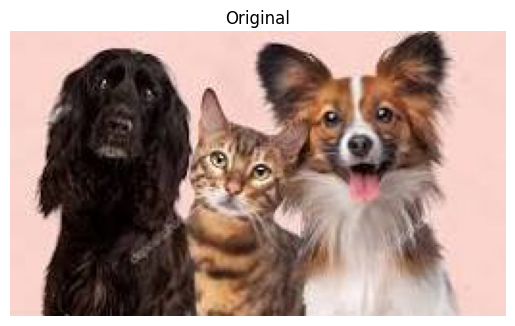

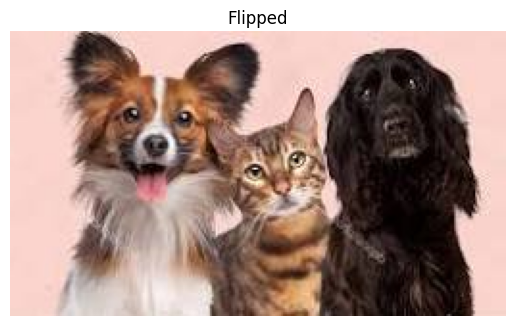

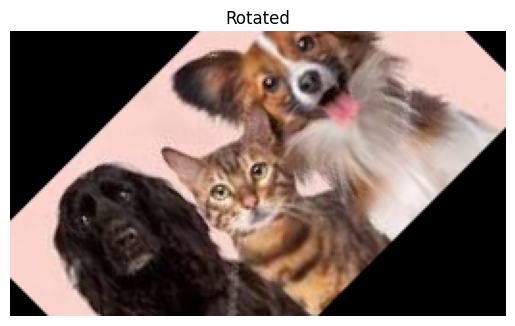

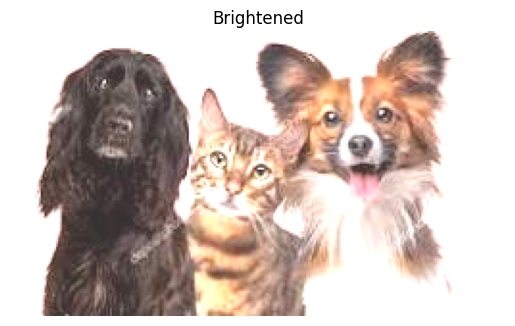

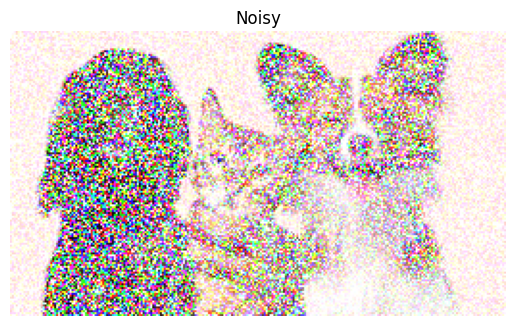

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_img(img, title="Image"):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

img = cv2.imread('/content/animals.jpg')
show_img(img, "Original")

flipped = cv2.flip(img, 1)
show_img(flipped, "Flipped")

(h, w) = img.shape[:2]
M = cv2.getRotationMatrix2D((w//2, h//2), 45, 1.0)
rotated = cv2.warpAffine(img, M, (w, h))
show_img(rotated, "Rotated")

bright = cv2.convertScaleAbs(img, alpha=1.2, beta=50)
show_img(bright, "Brightened")

noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
noisy = cv2.add(img, noise)
show_img(noisy, "Noisy")


## 📐 Линейная алгебра: Аффинные преобразования

In [ ]:
import numpy as np

A = np.array([[1.2, 0.3, 50],
              [-0.2, 1.1, 30],
              [0, 0, 1]])

print("Матрица A:")
print(A)

A_inv = np.linalg.inv(A)
print("\nОбратная матрица:")
print(A_inv)

point = np.array([100, 50, 1])
transformed = A @ point
restored = A_inv @ transformed

print("\nТочка после трансформации:", transformed)
print("Восстановленная точка:", restored)


Матрица A:
[[        1.2         0.3          50]
 [       -0.2         1.1          30]
 [          0           0           1]]

Обратная матрица:
[[     0.7971    -0.21739     -33.333]
 [    0.14493     0.86957     -33.333]
 [          0           0           1]]

Точка после трансформации: [        185          65           1]
Восстановленная точка: [        100          50           1]
